The purpose of this notebook is to look at the given set of selectors on a subset of (in this case) 3 cheeses (but this can be anything really) and find the optimal selectors to continue analysis with and collect additional data from for ML applications. <br>
Note: a lot of the stuff was originally written when testing on water v. ethanol data...so some names refer to this...sorry!

In [1]:
%matplotlib inline
import os
import itertools 
import warnings
import random
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.utils import shuffle
from sklearn.metrics import accuracy_score
from sklearn.metrics.pairwise import euclidean_distances
from sklearn.linear_model import LogisticRegressionCV, LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from scipy.cluster.hierarchy import dendrogram, linkage
from scipy.spatial.distance import pdist, squareform, euclidean
pd.options.display.max_columns=100
warnings.filterwarnings("ignore", category=DeprecationWarning)
import pickle

In [3]:
#### IMPORTANT: there are specifically tuned values in this cell for cheese data...see below and change if needed
# use the location of the data that has all 20 selectors
cheese = False
liquor = True
if cheese:
    norm_loc = './cheese_3_selectors_20/'
    data = {'c01':[], 'c02':[], 'c03':[],
            'm01':[], 'm02':[], 'm03':[],
            'p01':[], 'p02':[], 'p03':[]}
if liquor:
    norm_loc = './liquor_3_selectors_20/'
    data = {'r01':[], 'r02':[], 'r03':[],
            'v01':[], 'v02':[], 'v03':[],
            'w01':[], 'w02':[], 'w03':[]}
files = os.listdir(norm_loc)

# maps the column name of a excel file to the selector it came from 
mapper = {
'A':{1:'S1', 2:'S1', 3:'S1', 4:'S1',
     5:'S2', 6:'S2', 7:'S2', 8:'S2', 
     9:'S3', 10:'S3', 11:'S3', 12:'S3',
     13:'S4', 14:'S4', 15:'S4', 16:'S4'},
'B':{1:'S5', 2:'S5', 3:'S5', 4:'S5',
     5:'S6', 6:'S6', 7:'S6', 8:'S6', 
     9:'S7', 10:'S7', 11:'S7', 12:'S7',
     13:'S8', 14:'S8', 15:'S8', 16:'S8'},
'C':{1:'S9', 2:'S9', 3:'S9', 4:'S9',
     5:'S10', 6:'S10', 7:'S10', 8:'S10', 
     9:'S11', 10:'S11', 11:'S11', 12:'S11',
     13:'S12', 14:'S12', 15:'S12', 16:'S12'},
'D':{1:'S13', 2:'S13', 3:'S13', 4:'S13',
     5:'S14', 6:'S14', 7:'S14', 8:'S14', 
     9:'S15', 10:'S15', 11:'S15', 12:'S15',
     13:'S16', 14:'S16', 15:'S16', 16:'S16'},
'E':{1:'S17', 2:'S17', 3:'S17', 4:'S17',
     5:'S18', 6:'S18', 7:'S18', 8:'S18', 
     9:'S19', 10:'S19', 11:'S19', 12:'S19',
     13:'S20', 14:'S20', 15:'S20', 16:'S20'}
}

# go through all files and extract the data, keeping only the first sheet for all cases. 
for f in files:
    f = norm_loc + f
    selector_group = f[-6]
    # note these next values (indicies) are carefull matched to the data of interest!!! do change!!
    if cheese:
        if f[-14] == 'm':
            compound = 'm' + f[-9:-7]
        elif f[-17] == 'p':
            compound = 'p' + f[-9:-7]
        else:
            compound = 'c'+f[-9:-7]
    if liquor:
        if f[-16] == 'w':
            compound = 'w' + f[-9:-7]
        elif f[-12] == 'r':
            compound = 'r' + f[-9:-7]
        else:
            compound = 'v'+f[-9:-7]
    
    to_replace = mapper[selector_group]
    data_set = pd.read_excel(f, sheetname=None, header=None) # need to change sheetname to sheet_name for newer pd! ie if V runs
    for key in data_set.keys():
        data_set[key] = data_set[key].set_index(0)
        data_set[key] = data_set[key].rename(columns=to_replace)
    try:    
        data[compound].append(data_set['Sheet1']) # Currently working with just the first exposure. but with these data somewhere missing
    except:
        data[compound].append(data_set['Sheet2'])
for comp in data:  
    data[comp] = pd.concat(data[comp], axis=1)
if cheese:
    pickle.dump(data, open('./cheese_data.pkl','wb'))
if liquor:
    pickle.dump(data, open('./liquor_data.pkl','wb'))

In [3]:
# #### IMPORTANT: there are specifically tuned values in this cell for cheese data...see below and change if needed
# # use the location of the data that has all 20 selectors
# norm_loc = './liquor_3_selectors_20/'
# files = os.listdir(norm_loc)

# data = {'r01':[], 'r02':[], 'r03':[],
#         'v01':[], 'v02':[], 'v03':[],
#         'w01':[], 'w02':[], 'w03':[]}
# # maps the column name of a excel file to the selector it came from 
# mapper = {
# 'A':{1:'S1', 2:'S1', 3:'S1', 4:'S1',
#      5:'S2', 6:'S2', 7:'S2', 8:'S2', 
#      9:'S3', 10:'S3', 11:'S3', 12:'S3',
#      13:'S4', 14:'S4', 15:'S4', 16:'S4'},
# 'B':{1:'S5', 2:'S5', 3:'S5', 4:'S5',
#      5:'S6', 6:'S6', 7:'S6', 8:'S6', 
#      9:'S7', 10:'S7', 11:'S7', 12:'S7',
#      13:'S8', 14:'S8', 15:'S8', 16:'S8'},
# 'C':{1:'S9', 2:'S9', 3:'S9', 4:'S9',
#      5:'S10', 6:'S10', 7:'S10', 8:'S10', 
#      9:'S11', 10:'S11', 11:'S11', 12:'S11',
#      13:'S12', 14:'S12', 15:'S12', 16:'S12'},
# 'D':{1:'S13', 2:'S13', 3:'S13', 4:'S13',
#      5:'S14', 6:'S14', 7:'S14', 8:'S14', 
#      9:'S15', 10:'S15', 11:'S15', 12:'S15',
#      13:'S16', 14:'S16', 15:'S16', 16:'S16'},
# 'E':{1:'S17', 2:'S17', 3:'S17', 4:'S17',
#      5:'S18', 6:'S18', 7:'S18', 8:'S18', 
#      9:'S19', 10:'S19', 11:'S19', 12:'S19',
#      13:'S20', 14:'S20', 15:'S20', 16:'S20'}
# }

# # go through all files and extract the data, keeping only the first sheet for all cases. 
# for f in files:
#     f = norm_loc + f
#     selector_group = f[-6]
#     # note these next values (indicies) are carefull matched to the data of interest!!! do change!!
#     if f[-16] == 'w':
#         compound = 'w' + f[-9:-7]
#     elif f[-12] == 'r':
#         compound = 'r' + f[-9:-7]
#     else:
#         compound = 'v'+f[-9:-7]
#     to_replace = mapper[selector_group]
#     data_set = pd.read_excel(f, sheetname=None, header=None) # need to change sheetname to sheet_name for newer pd! ie if V runs
#     for key in data_set.keys():
#         data_set[key] = data_set[key].set_index(0)
#         data_set[key] = data_set[key].rename(columns=to_replace)
#     try:    
#         data[compound].append(data_set['Sheet1']) # Currently working with just the first exposure. but with these data somewhere missing
#     except:
#         data[compound].append(data_set['Sheet2'])
# for comp in data:  
#     data[comp] = pd.concat(data[comp], axis=1)

In [4]:
### defining the majority of the functions

def get_classifier(classifier):
    if classifier == 'LR':
        return LogisticRegressionCV(cv=3, penalty='l1', solver='saga', n_jobs=-1)
    elif classifier == 'RF':
        return RandomForestClassifier(n_estimators=100, n_jobs=-1)
    elif classifier == 'KNN':
        return KNeighborsClassifier(n_neighbors=1, n_jobs=-1)
    elif classifier == 'SVM': # using the default RBF kernel..
        return SVC() 
    elif classifier == 'GP':
        kernel = 1.0 * RBF(1.0)
        return GaussianProcessClassifier(kernel=kernel, n_jobs=-1)
    else:
        print('You did not input a valid classifier, please use one of: KNN, LR or RF')
        return
    
def get_majority_vote(vote_count_dict):
    highest_count = 0
    key_highest = None
    shared_highest = []
    for k,v in vote_count_dict.items():
        if v > highest_count:
            highest_count = v
            key_highest = k
            shared_highest = [(k,v)]
        elif v == highest_count:
            shared_highest.append((k,v))
    if len(shared_highest) > 1:
        rand_int = random.randint(0,len(shared_highest)-1)
        key_highest = shared_highest[rand_int][0]
        # get random value in 0..len(shared_highest) and use this to set the key_highest
    return key_highest

def normalize_selector(sel_data):
    max_val = sel_data.max()
    min_val = sel_data.min()
    max_min = max_val - min_val
    sel_data = (sel_data - min_val) / float(max_min)
    return sel_data

def indiv_sel_avg_all_to_all_dist(sel_mat, classes):
    sample_num = sel_mat.shape[0]
    class_mat_list = np.split(sel_mat, classes, axis=0)
    all_dists = []
    seen = []
    for int_1, class_mat_1 in enumerate(class_mat_list):
        for int_2, class_mat_2 in enumerate(class_mat_list):
            if int_1 == int_2:
                continue
            if (int_1,int_2) in seen or (int_2,int_1) in seen:
                continue
            seen.append((int_1, int_2))
            distances = euclidean_distances(class_mat_1, class_mat_2)
            mean = distances.mean()
            all_dists.append(mean)
    all_distances = np.asarray(all_dists)
    return all_distances.sum()

def internal_class_dissim(sel_mat, classes):
    sample_num = sel_mat.shape[0]
    class_mat_list = np.split(sel_mat, classes, axis=0)
    class_distances = []
    for class_mat in class_mat_list:
        distances = euclidean_distances(class_mat, class_mat)
        distances = distances.round(5)
        linear_mat = squareform(distances)
        class_distances.append((linear_mat.mean(), linear_mat.std()))
    return class_distances
         
def avg_all_to_all_dist(m1, m2):
    distances = []
    for i in range(m1.shape[0]):
        for j in range(m2.shape[0]):
            distances.append(euclidean(m1[i,:], m2[j,:]))
    distances = np.asarray(distances)
    distance_mean = distances.mean()
    return distance_mean

def dist_water_and_ethanol(selector1, selector2):
    '''
    currently hardcoded for the water-ethanol datasets assuming sorted input! ie ethanol first, then water
    '''
    ethanol_dist = avg_all_to_all_dist(selector1[:12,:], selector2[:12,:])
    water_dist = avg_all_to_all_dist(selector1[12:,:], selector2[12:,:])
    return water_dist, ethanol_dist

In [34]:
### IMPORTANT: only run if you need to extract these files for the 3/5 cheese analysis with 4 selectors!! 
### These selectors came from the analysis of this notebook. 

# purpose of this is to extract the 4,5,6 and 20 data from each example cheese and write to a new file 
# this is for prep for use with the optimal_selector_cheese notebook


#### DONT EVER USE WANT THE TEST SET TO BE INDEPENDENT FROM THIS!!!

# for cheese in data: 
#     best_data = data[cheese][['S4', 'S5', 'S6', 'S20']]
#     if cheese[0] == 'c':
#         cheese_name = 'cheddar'+cheese[1:]
#     elif cheese[0] == 'p':
#         cheese_name = 'pecorino'+cheese[1:]
#     elif cheese[0] == 'm':
#         cheese_name = 'mahon'+cheese[1:]
#     name = 'Norm_2019_01_31_{}.xlsx'.format(cheese_name)
#     print(name)
#     best_data.to_excel(name, header=False)

Norm_2019_01_31_cheddar01.xlsx
Norm_2019_01_31_cheddar02.xlsx
Norm_2019_01_31_cheddar03.xlsx
Norm_2019_01_31_mahon01.xlsx
Norm_2019_01_31_mahon02.xlsx
Norm_2019_01_31_mahon03.xlsx
Norm_2019_01_31_pecorino01.xlsx
Norm_2019_01_31_pecorino02.xlsx
Norm_2019_01_31_pecorino03.xlsx


For doing featurization on the data using tsfresh

In [5]:
from tsfresh import extract_features
from tsfresh import select_features
from tsfresh.utilities.dataframe_functions import impute
import itertools

# getting the data into a format for the extract_features....
start = 300
end = 600
length= end-start
selectors = [i+1 for i in range(20)]
combined = []
for select in selectors:
    selector = []
    for w in sorted(data.keys()):
        selector_data = data[w]['S'+str(select)]
        selector_data = selector_data.T.fillna(selector_data.mean(axis=1)).T 
        selector.append(selector_data)
    selector = pd.concat(selector, axis=1)
    selector = selector.values.T
    selector = selector[:, start:end].reshape(-1,1)
    combined.append(selector)
combined = np.concatenate(combined, axis=1)
time = np.asarray([i for i in range(end-start)]*36).reshape(-1,1) # 4 (replicates in a TC) * 3 repeats *3 cheese = 36
combined = np.append(combined,time, axis=1)
combined_df = pd.DataFrame(combined, columns=['S1','S2','S3','S4','S5','S6','S7','S8','S9','S10','S11',
                                              'S12','S13','S14','S15','S16','S17','S18','S19','S20','time'])
if cheese:
    name_c = ['C1_{}'.format(i) for i in range(1,13)] # 12 examples for cheese 1
    name_c = [[ele]*length for ele in name_c]
    name_c = [j for i in name_c for j in i]
    name_m = ['M1_{}'.format(i) for i in range(1,13)] # 12 examples for cheese 2
    name_m = [[ele]*length for ele in name_m]
    name_m = [j for i in name_m for j in i]
    name_p = ['P1_{}'.format(i) for i in range(1,13)] # 12 examples for cheese 3
    name_p = [[ele]*length for ele in name_p]
    name_p = [j for i in name_p for j in i]
    names = name_c + name_m + name_p
if liquor:
    name_r = ['R1_{}'.format(i) for i in range(1,13)] # 12 examples for cheese 1
    name_r = [[ele]*length for ele in name_r]
    name_r = [j for i in name_r for j in i]
    name_v = ['V1_{}'.format(i) for i in range(1,13)] # 12 examples for cheese 2
    name_v = [[ele]*length for ele in name_v]
    name_v = [j for i in name_v for j in i]
    name_w = ['W1_{}'.format(i) for i in range(1,13)] # 12 examples for cheese 3
    name_w = [[ele]*length for ele in name_w]
    name_w = [j for i in name_w for j in i]
    names = name_r + name_v + name_w
combined_df['id'] = names

extracted_feat = extract_features(combined_df, column_id="id", column_sort="time", column_kind=None, column_value=None)
impute(extracted_feat)# fill in the nan features 
if cheese:
    pickle.dump(extracted_feat, open('./featurized_cheese.pkl', 'wb'))
if liquor:
    pickle.dump(extracted_feat, open('./featurized_liquor.pkl', 'wb'))
# each selector has 794 features...can split this dataframe up and train on individuals or together...

Feature Extraction: 100%|██████████| 20/20 [03:06<00:00,  5.15s/it]


In [45]:
column_names = list(extracted_feat)
new_names = []
for col in column_names:
    if 'S7' in col or 'S10' in col or 'S11' in col or 'S12' in col:
        new_names.append(col)
minextracted = extracted_feat[new_names]
minextracted
print(minextracted.shape)

(36, 3176)


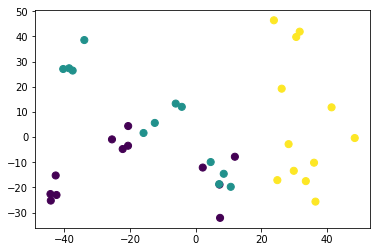

In [52]:
labels = np.array([[0,1,2]])
labels = np.repeat(labels, 12, axis=1).flatten()

# get just the good selectors: 7,10,11,12


ss = StandardScaler()
pca = PCA(n_components=10)
X = ss.fit_transform(minextracted)
X_pca = pca.fit_transform(X)
plt.scatter(X_pca[:,0], X_pca[:,1], s=50, c=labels)
plt.savefig('./liquor_3_selectors_20/PCA_7_10_11_12.png'.format(i))
# plt.gcf().clear()
plt.show()

In [8]:
    ##### FIRST KEY METHOD FOR FINDING SELECTORS ######

    # note score is an accuracy!! not auc
    classifier = 'RF'
    labels = np.array([[0,1,2]])
    labels = np.repeat(labels, 12, axis=1).flatten()
    ### this select_features is a tsfresh function that im not 100% sure on how it works...so tending not to use
    # features_filtered = select_features(extracted_feat, labels)

    # ok need to get the names for the selectors and the ORDER they are in, in the dataframe..cause its not 1,2,3..20
    selector_names = list(extracted_feat)
    # selector_names = list(minextracted)
    seen = []
    for ele in selector_names:
        if ele[:3] not in seen:
            seen.append(ele[:3])
        else:
            pass
    selector_order = [ele[:-1] if ele[-1] == '_' else ele for ele in seen]

    # need to properly sort the df coming in so the blocks work! 
    if cheese:
        name_c = ['C1_{}'.format(i) for i in range(1,13)]
        name_m = ['M1_{}'.format(i) for i in range(1,13)]
        name_p = ['P1_{}'.format(i) for i in range(1,13)]
        names = name_c + name_m + name_p
    if liquor:
        name_r = ['R1_{}'.format(i) for i in range(1,13)]
        name_v = ['V1_{}'.format(i) for i in range(1,13)]
        name_w = ['W1_{}'.format(i) for i in range(1,13)]
        names = name_r + name_v + name_w    
    extracted_feat = extracted_feat.loc[names]
    # minextracted = minextracted.loc[names]

    # to properly do selection, going to keep the blocks of selectors together
    blocks = [[0,1,2,3],[4,5,6,7],[8,9,10,11],[12,13,14,15],[16,17,18,19],[20,21,22,23],
              [24,25,26,27],[28,29,30,31],[32,33,34,35]]
    block_combos = [(0,3,6),(0,3,7),(0,3,8),(0,4,6),(0,4,7),(0,4,8),(0,5,6),(0,5,7),(0,5,8),
                    (1,3,6),(1,3,7),(1,3,8),(1,4,6),(1,4,7),(1,4,8),(1,5,6),(1,5,7),(1,5,8),
                    (2,3,6),(2,3,7),(2,3,8),(2,4,6),(2,4,7),(2,4,8),(2,5,6),(2,5,7),(2,5,8)]

    # ok loop over selectors, then get the data from one selector, then run a repeat of 20x with shuffling of train / test and get results 
    # FOR that selector
    accuracies = {}
    for j, sel_name in zip(range(20),selector_order): # looping over the selectors
        selector_accuracy = []
        for combo in block_combos: # looping over the different blocks 
            data_combined_sh, labels_sh = extracted_feat.values, labels
            mask_test = blocks[combo[0]]+blocks[combo[1]]+blocks[combo[2]]
            mask_train = [i for i in range(labels.shape[0]) if i not in mask_test]
            x_test =  data_combined_sh[mask_test,:]
            x_train =  data_combined_sh[mask_train,:]
            y_test = labels_sh[mask_test]
            y_train = labels_sh[mask_train]
            x_train, y_train = shuffle(x_train, y_train)
            # now split up for the different selectors 
            x_train_list = np.split(x_train,20, axis=1)
            x_test_list = np.split(x_test,20, axis=1)
            x_tr, x_ts = x_train_list[j], x_test_list[j]
            pred_test_combined = []
            clf = get_classifier(classifier)
            clf.fit(x_tr, y_train)
            selector_accuracy.append(clf.score(x_ts, y_test))
        selector_accuracy = np.asarray(selector_accuracy)
        accuracies[sel_name] = ['{:.3f}+/-{:.3f}'.format(selector_accuracy.mean(), selector_accuracy.std())]
    featurized_indiv_select_acc = pd.DataFrame.from_dict(accuracies)
    if cheese:
        featurized_indiv_select_acc.to_csv('./3_cheese_featurized_indiv_selector_accuracies.csv')
    if liquor:
        featurized_indiv_select_acc.to_csv('./3_liquor_featurized_indiv_selector_accuracies.csv')

In [39]:
##### NOT IMPORTANT FOR FINDING USEFUL SELECTORS - JUST SHOWING THE VOTING OVER ALL SELECTORS WITH FEATURES IS GOO

# just for training a model with voting from all features...it gets 1 auc...
classifier = 'RF'
labels = np.array([[0,1,2]])
labels = np.repeat(labels, 12, axis=1).flatten()
### this select_features is a tsfresh function that im not 100% sure on how it works...so tending not to use
# features_filtered = select_features(extracted_feat, labels)
# features_filtered.shape

# data_combined_sh, labels_sh = shuffle(extracted_feat.values, labels)
data_combined_sh, labels_sh = shuffle(minextracted.values, labels)
x_train, x_test, y_train, y_test = train_test_split(data_combined_sh, labels_sh, test_size=0.15)
# 20 splits due to 20 selectors!
# x_train_list = np.split(x_train,20, axis=1)
# x_test_list = np.split(x_test,20, axis=1)
x_train_list = np.split(x_train,4, axis=1)
x_test_list = np.split(x_test,4, axis=1)
# this 794 is from the number of features each of the selectors has in the new df...might need to change
# you can get it from the commented out code at the end of this cell...'note see above....' this chunk

accuracies = []
# for j in range(20):
for j in range(4):
    pred_test_combined = []
    for x_tr, x_ts in zip(x_train_list,x_test_list):
        clf = get_classifier(classifier)
        clf.fit(x_tr, y_train)
        pred_test_combined.append(clf.predict(x_ts))
    pred_test_combined = np.concatenate(pred_test_combined)
    pred_test_combined = pred_test_combined.reshape((-1,y_test.shape[0]))
    combined_vote = []
    for i in range(y_test.shape[0]):
        unique, counts = np.unique(pred_test_combined[:,i], return_counts=True)
        counts = dict(zip(unique, counts))
        majority = get_majority_vote(counts)
        combined_vote.append(majority)
    combined_vote = np.asarray(combined_vote)
    accuracies.append(accuracy_score(y_test, combined_vote))
accuracies = np.asarray(accuracies)
print('the accuracy is ', accuracies.mean(), '+/-', accuracies.std())

the accuracy is  1.0 +/- 0.0


In [9]:
##### SECOND MAIN WAY FOR SELECTING THE SELECTORS TO CARRY ON WITH:
##### Idea is to train models (KNN or GP etc) using a time cource-to-time course distance function then classify that way
##### Do it selector by selector to see which has the most signal 

# do you want to randomly drop parts of the input and shuffle to avoid dependence between features (ie different time points
# in a single time course)
random_drop = False
num_to_keep = 50
# what time window do you want to use?
start = 300
end = 600
classifier = 'KNN' # Use LR - logistic regression, RF - random forest, KNN - k-nearest neighbors, SVM - support vector machine
# fit models on all combos of the data blocks: 

### CHANGE FOR 2 v 3 cheeses 
# blocks = [[0,1,2,3],[4,5,6,7],[8,9,10,11],[12,13,14,15],[16,17,18,19],[20,21,22,23]]
# block_combos = [(0,3),(0,4),(0,5),(1,3),(1,4),(1,5),(2,3),(2,4),(2,5)]
blocks = [[0,1,2,3],[4,5,6,7],[8,9,10,11],[12,13,14,15],[16,17,18,19],[20,21,22,23],
          [24,25,26,27],[28,29,30,31],[32,33,34,35],[36,37,38,39],[40,41,42,43],[]]
block_combos = [(0,3,6),(0,3,7),(0,3,8),(0,4,6),(0,4,7),(0,4,8),(0,5,6),(0,5,7),(0,5,8),
                (1,3,6),(1,3,7),(1,3,8),(1,4,6),(1,4,7),(1,4,8),(1,5,6),(1,5,7),(1,5,8),
                (2,3,6),(2,3,7),(2,3,8),(2,4,6),(2,4,7),(2,4,8),(2,5,6),(2,5,7),(2,5,8)]

#get a array for the labels for the wines...there are four wines so four labels
###  CHANGE FOR 2 v 3 cheeses
# labels = np.array([[0,1]])
labels = np.array([[0,1,2]])
labels = np.repeat(labels, 12, axis=1).flatten()

# ok now run on individual selectors for each of the blocks of train / test
# its called a selector drop list but in reality its just the selector thats used....
selector_drop_list = [[1],[2],[3],[4],[5],[6],[7],[8],[9],[10],[11],[12],[13],[14],[15],[16],[17],[18],[19],[20]]
selector_acc_dict = {}
s = 1
for selector_list in selector_drop_list:
    accuracies = []
    for combo in block_combos:
        pred_test_combined = []
        # retrieve the selector data for the specific selector
        for i in selector_list:
            selector = []
            for w in sorted(data.keys()):
                selector_data = data[w]['S'+str(i)]
                # In case data is missing this imputes via the mean; probably a better idea to just drop...
                # (but the ethanol-water does not have this issue)
                selector_data = selector_data.T.fillna(selector_data.mean(axis=1)).T 
                selector.append(selector_data)
            selector = pd.concat(selector, axis=1)
            selector = selector.values.T
            selector = selector[:, start:end]
            if random_drop:
                rand_kept = np.random.choice(selector.shape[1], num_to_keep)
                selector = selector[:,rand_kept]
            #### CRITICAL TO CHANGE
            mask_test = blocks[combo[0]]+blocks[combo[1]]+blocks[combo[2]]
#             mask_test = blocks[combo[0]]+blocks[combo[1]]
            mask_train = [i for i in range(labels.shape[0]) if i not in mask_test]
            x_test = selector[mask_test,:]
            x_train = selector[mask_train,:]
            y_test = labels[mask_test]
            y_train = labels[mask_train]
            
            clf = get_classifier(classifier)
            x_train, y_train = shuffle(x_train, y_train)
            clf.fit(x_train, y_train)
            accuracies.append(clf.score(x_test, y_test))
    accuracies = np.asarray(accuracies)
    selector_acc_dict['sel_{}'.format(s)] = ['{:.3f}+/-{:.3f}'.format(accuracies.mean(), accuracies.std())]
    s += 1
featurized_indiv_select_acc = pd.DataFrame.from_dict(selector_acc_dict)
if cheese:
    featurized_indiv_select_acc.to_csv('./3_cheese_{}_finding_selector_accuracies.csv'.format(classifier))
if liquor:
    featurized_indiv_select_acc.to_csv('./3_liquor_{}_finding_selector_accuracies.csv'.format(classifier))
featurized_indiv_select_acc    
             
#             pred_test_combined.append(clf.predict(x_test)) # might be better to work with probablilites... predict_proba
#         pred_test_combined = np.concatenate(pred_test_combined)
#         pred_test_combined = pred_test_combined.reshape((-1,y_test.shape[0]))
#         combined_vote = []
#         for i in range(y_test.shape[0]):
#             unique, counts = np.unique(pred_test_combined[:,i], return_counts=True)
#             counts = dict(zip(unique, counts))
#             majority = get_majority_vote(counts)
#             combined_vote.append(majority)
#         combined_vote = np.asarray(combined_vote)
#         accuracies.append(accuracy_score(y_test, combined_vote))
#     accuracies = np.asarray(accuracies)
# #     print('accuracy list:', accuracies)
#     print('when removing selector {}, the accuracy is '.format(s), accuracies.mean(), '+/-', accuracies.std())
#     s += 1
    
###### notes from trying different params:    
    
    # for 2 cheeses with KNN = 1
    # S1:0.47, S2:0.54, S3:0.60, S4:0.90, S5:0.875, S6:0.92, S7:0.79, S8:0.53, S9:0.43, S10:0.81,
    # S11:0.42, S12:0.56, S13:0.44, S14:0.19, S15:0.47, S16:0.57, S17:0.47, S18:0.46, S19:0.34, S20:0.625
    
    # for 3 cheeses with KNN = 1
    # s1:0.32 s2:0.35 s3:0.52 s4:0.85 s5:0.60 s6:0.77 s7:0.64 s8:0.54 s9:0.43 s10:0.5 
    # s11:0.26 s12:0.32 s13:0.48 s14:0.28 s15:0.45 s16:0.16 s17:0.50 s18:0.46 s19:0.33 s20: 0.75
    # positive signal >0.4: 3,4,5,6,7,8,9,10,13,15,17,18,20
    # positive signal >=0.5: 3,4,5,6,7,8,10,17,20
    # positive signal >0.5: 3,4,5,6,7,8,20
    # psotive signal >=0.6: 4,5,6,7,20
    
    # for GP with RBF
    # S1:0.21, S2:0.37, S3:0.49, S4:0.84, S5:0.70, S6:0.79, S7:0.66, S8:0.59, S9:0.37, S10:0.47
    # S11:0.26, S12:0.42, S13:0.55, S14:0.32, S15:0.5, S16:0.19, S17:0.52, S18:0.45, S19:0.29, S20:0.80

,sel_1,sel_2,sel_3,sel_4,sel_5,sel_6,sel_7,sel_8,sel_9,sel_10,sel_11,sel_12,sel_13,sel_14,sel_15,sel_16,sel_17,sel_18,sel_19,sel_20
0,0.380+/-0.159,0.441+/-0.187,0.358+/-0.145,0.370+/-0.159,0.213+/-0.119,0.262+/-0.087,0.620+/-0.114,0.466+/-0.138,0.460+/-0.235,0.478+/-0.200,0.549+/-0.204,0.759+/-0.176,0.167+/-0.155,0.238+/-0.158,0.389+/-0.165,0.478+/-0.151,0.222+/-0.142,0.130+/-0.107,0.136+/-0.138,0.451+/-0.140


In [10]:
# do you want to randomly drop parts of the input and shuffle to avoid dependence between features (ie different time points
# in a single time course)
random_drop = False
num_to_keep = 50
# what time window do you want to use?
start = 300
end = 600
classifier = 'GP' # Use LR - logistic regression, RF - random forest, KNN - k-nearest neighbors, SVM - support vector machine
# fit models on all combos of the data blocks: 

### CHANGE FOR 2 v 3 cheeses 
# blocks = [[0,1,2,3],[4,5,6,7],[8,9,10,11],[12,13,14,15],[16,17,18,19],[20,21,22,23]]
# block_combos = [(0,3),(0,4),(0,5),(1,3),(1,4),(1,5),(2,3),(2,4),(2,5)]
blocks = [[0,1,2,3],[4,5,6,7],[8,9,10,11],[12,13,14,15],[16,17,18,19],[20,21,22,23],
          [24,25,26,27],[28,29,30,31],[32,33,34,35],[36,37,38,39],[40,41,42,43],[]]
block_combos = [(0,3,6),(0,3,7),(0,3,8),(0,4,6),(0,4,7),(0,4,8),(0,5,6),(0,5,7),(0,5,8),
                (1,3,6),(1,3,7),(1,3,8),(1,4,6),(1,4,7),(1,4,8),(1,5,6),(1,5,7),(1,5,8),
                (2,3,6),(2,3,7),(2,3,8),(2,4,6),(2,4,7),(2,4,8),(2,5,6),(2,5,7),(2,5,8)]

#get a array for the labels for the wines...there are four wines so four labels
###  CHANGE FOR 2 v 3 cheeses
# labels = np.array([[0,1]])
labels = np.array([[0,1,2]])
labels = np.repeat(labels, 12, axis=1).flatten()

# ok now run on individual selectors for each of the blocks of train / test
# its called a selector drop list but in reality its just the selector thats used....
selector_drop_list = [[1],[2],[3],[4],[5],[6],[7],[8],[9],[10],[11],[12],[13],[14],[15],[16],[17],[18],[19],[20]]
selector_acc_dict = {}
s = 1
for selector_list in selector_drop_list:
    accuracies = []
    for combo in block_combos:
        pred_test_combined = []
        # retrieve the selector data for the specific selector
        for i in selector_list:
            selector = []
            for w in sorted(data.keys()):
                selector_data = data[w]['S'+str(i)]
                # In case data is missing this imputes via the mean; probably a better idea to just drop...
                # (but the ethanol-water does not have this issue)
                selector_data = selector_data.T.fillna(selector_data.mean(axis=1)).T 
                selector.append(selector_data)
            selector = pd.concat(selector, axis=1)
            selector = selector.values.T
            selector = selector[:, start:end]
            if random_drop:
                rand_kept = np.random.choice(selector.shape[1], num_to_keep)
                selector = selector[:,rand_kept]
            #### CRITICAL TO CHANGE
            mask_test = blocks[combo[0]]+blocks[combo[1]]+blocks[combo[2]]
#             mask_test = blocks[combo[0]]+blocks[combo[1]]
            mask_train = [i for i in range(labels.shape[0]) if i not in mask_test]
            x_test = selector[mask_test,:]
            x_train = selector[mask_train,:]
            y_test = labels[mask_test]
            y_train = labels[mask_train]
            
            clf = get_classifier(classifier)
            x_train, y_train = shuffle(x_train, y_train)
            clf.fit(x_train, y_train)
            accuracies.append(clf.score(x_test, y_test))
    accuracies = np.asarray(accuracies)
    selector_acc_dict['sel_{}'.format(s)] = ['{:.3f}+/-{:.3f}'.format(accuracies.mean(), accuracies.std())]
    s += 1
featurized_indiv_select_acc = pd.DataFrame.from_dict(selector_acc_dict)
if cheese:
    featurized_indiv_select_acc.to_csv('./3_cheese_{}_finding_selector_accuracies.csv'.format(classifier))
if liquor:
    featurized_indiv_select_acc.to_csv('./3_liquor_{}_finding_selector_accuracies.csv'.format(classifier))
featurized_indiv_select_acc

,sel_1,sel_2,sel_3,sel_4,sel_5,sel_6,sel_7,sel_8,sel_9,sel_10,sel_11,sel_12,sel_13,sel_14,sel_15,sel_16,sel_17,sel_18,sel_19,sel_20
0,0.367+/-0.173,0.509+/-0.176,0.253+/-0.098,0.333+/-0.000,0.284+/-0.140,0.278+/-0.113,0.540+/-0.110,0.444+/-0.187,0.512+/-0.234,0.596+/-0.243,0.651+/-0.176,0.781+/-0.168,0.216+/-0.185,0.216+/-0.162,0.444+/-0.187,0.367+/-0.137,0.231+/-0.169,0.074+/-0.092,0.117+/-0.158,0.451+/-0.147


This following cell is for using each selector individually with kNN, RF, lr and SVM classifiers and then using majority voting over the classifier. its more for playing around with the 'optimal' selectors from the previous cell... <br>
NOT GOOD ML PRACTICE DONT USE IN PRODUCTION...WE ARE GETTING ADDITIONAL DATA USING THE OPTIMIZED SELECTORS

In [19]:
##### NOT USED FOR OBTAINING OPTIMAL SELECTORS...its just to play around with how select ones would do
##### (note due to small data the same data is used that was used for finding the optimal selectors...so dont use in practice)
##### this block is for testing models using KNN etc type classifiers with select selector lists in a blocked manner

# do you want to randomly drop parts of the input and shuffle to avoid dependence between features (ie different time points
# in a single time course)
random_drop = False
num_to_keep = 50
# what time window do you want to use?
start = 300
end = 600
classifier = 'KNN' # Use LR - logistic regression, RF - random forest, KNN - k-nearest neighbors, SVM - support vector machine
# fit models on all combos of the data blocks: 
# blocks = [[0,1,2,3],[4,5,6,7],[8,9,10,11],[12,13,14,15],[16,17,18,19],[20,21,22,23]]
# block_combos = [(0,3),(0,4),(0,5),(1,3),(1,4),(1,5),(2,3),(2,4),(2,5)]

blocks = [[0,1,2,3],[4,5,6,7],[8,9,10,11],[12,13,14,15],[16,17,18,19],[20,21,22,23],
          [24,25,26,27],[28,29,30,31],[32,33,34,35]]
block_combos = [(0,3,6),(0,3,7),(0,3,8),(0,4,6),(0,4,7),(0,4,8),(0,5,6),(0,5,7),(0,5,8),
                (1,3,6),(1,3,7),(1,3,8),(1,4,6),(1,4,7),(1,4,8),(1,5,6),(1,5,7),(1,5,8),
                (2,3,6),(2,3,7),(2,3,8),(2,4,6),(2,4,7),(2,4,8),(2,5,6),(2,5,7),(2,5,8)]

#get a array for the labels for the wines...there are four wines so four labels
# labels = np.array([[0,1]])
labels = np.array([[0,1,2]])
labels = np.repeat(labels, 12, axis=1).flatten()

# selector_lists = []
# s_list = [3,4,5,6,7,8,10,20]
# for L in range(2, len(s_list)+1):
#     for com in itertools.combinations(s_list,L):
#         selector_lists.append(com)
selector_lists = [[7, 11, 12],[10, 11, 12],[7, 10, 11, 12], [17,18, 19],[7, 9, 12], [7, 10, 12], [7,12,15]] ####### CHANGE THIS!!!!!! #######

for selector_list in selector_lists:
    print('selector list is: ', selector_list)
    accuracies = []
    for combo in block_combos:
#         print('On combo: ', combo)
        # each combo will give 20 models where each 
        pred_test_combined = []
    #     selector_list = [3,4,5,6,7,8,10,20]
        # 2 cheeses:
        # 4,5,10 = 0.90 +- 0.08
        # 4,5,6 = 0.99 +- 0.04
        # 4,5,6,10 = 0.93 +- 0.06
        # 4,5,6,7,10 = 0.94 +- 0.06
        
        # for 3 cheeses:
        # 4,5,6 = 0.83 +- 0.09
        # 4,6,20 = .94 +- 0.07
        # 4,5,6,7,20 = 0.91+-0.11
        # 3,4,5,6,7,20 = 0.89 +-0.10
        # 4,5,6,7,8,20 = 0.88 +- 0.11
        # 3,4,5,6,7,8,20 = 0.91 +-0.11
        # 3,4,5,6,7,8,10,20 = 0.87 +- 0.12
        
        # GP:
        # 4,6,20 = 0.95 +- 0.06
        # 4,5,6,20 = 0.92 +- 0.07
        # 4,5,6,7,20 = 0.93 +- 0.07
        
        # GP liq:
        # [7, 11, 12] = 0.75 +/- 0.14
        # [10, 11, 12] = 0.77 +/- 0.20
        # [7, 10, 11, 12] = 0.78 +/- 0.17
        # [17,18, 19] = 0.14 +/- 0.15 testing to show its actually bad 
        # [7, 9, 12] = 0.69 +/- 0.16
        # [7, 10, 12] = 0.73 +/- 0.19
        # [7, 12, 15] = 0.68 +/- 0.17
        
        # KNN liq:
        # [7, 11, 12] = 0.74 +/- 0.13
        # [10, 11, 12] = 0.65 +/- 0.24
        # [7, 10, 11, 12] = 0.71 +/- 0.14
        # [17,18, 19] = 0.16 +/- 0.15  testing to show its actually bad 
        # [7, 9, 12] = 0.68 +/- 0.15
        # [7, 10, 12] = 0.69 +/- 0.20
        # [7, 12, 15] = 0.68 +/- 0.16
        
        for i in selector_list:
    #     for i in range(1,21):
            selector = []
            for w in sorted(data.keys()):
                selector_data = data[w]['S'+str(i)]
                # In case data is missing this imputes via the mean; probably a better idea to just drop...
                # (but the ethanol-water does not have this issue)
                selector_data = selector_data.T.fillna(selector_data.mean(axis=1)).T 
                selector.append(selector_data)
            selector = pd.concat(selector, axis=1)
            selector = selector.values.T
            selector = selector[:, start:end]
            if random_drop:
                rand_kept = np.random.choice(selector.shape[1], num_to_keep)
                selector = selector[:,rand_kept]
            ##### CRITICAL TO CHANGE!!!!
#             mask_test = blocks[combo[0]]+blocks[combo[1]]
            mask_test = blocks[combo[0]]+blocks[combo[1]]+blocks[combo[2]]
            mask_train = [i for i in range(labels.shape[0]) if i not in mask_test]
            x_test = selector[mask_test,:]
            x_train = selector[mask_train,:]
            y_test = labels[mask_test]
            y_train = labels[mask_train]

            clf = get_classifier(classifier)
            x_train, y_train = shuffle(x_train, y_train)
            clf.fit(x_train, y_train)
            pred_test_combined.append(clf.predict(x_test)) # might be better to work with probablilites... predict_proba
        pred_test_combined = np.concatenate(pred_test_combined)
        pred_test_combined = pred_test_combined.reshape((-1,y_test.shape[0]))
        combined_vote = []
        for i in range(y_test.shape[0]):
            unique, counts = np.unique(pred_test_combined[:,i], return_counts=True)
            counts = dict(zip(unique, counts))
            majority = get_majority_vote(counts)
            combined_vote.append(majority)
        combined_vote = np.asarray(combined_vote)
        accuracies.append(accuracy_score(y_test, combined_vote))
    accuracies = np.asarray(accuracies)
    print(accuracies.mean(), '+/-', accuracies.std())

selector list is:  [7, 11, 12]
0.7407407407407406 +/- 0.13094570021973104
selector list is:  [10, 11, 12]
0.6512345679012346 +/- 0.23899334176056714
selector list is:  [7, 10, 11, 12]
0.7129629629629629 +/- 0.1422434397753446
selector list is:  [17, 18, 19]
0.16049382716049382 +/- 0.1450945589326316
selector list is:  [7, 9, 12]
0.6790123456790123 +/- 0.15499851270974963
selector list is:  [7, 10, 12]
0.6913580246913581 +/- 0.19748263300057273
selector list is:  [7, 12, 15]
0.6790123456790125 +/- 0.16149969693766825


OK a few cute plotting boxes...showing the time courses and also calculating and visualizing the distances between time courses!

In [47]:
# plot all of the data to get a feel for it. 
start = 300
end = 600
normalize = False
colors = ['c','c','c','c','c','c','c','c','c','c','c','c',
          'g','g','g','g','g','g','g','g','g','g','g','g',
          'k','k','k','k','k','k','k','k','k','k','k','k']

for i in range(1,21):
    selector = []
    for w in sorted(data.keys()):
        selector.append(data[w]['S'+str(i)])
    selector = pd.concat(selector, axis=1)
    selector = selector.values.T
    selector = selector[:, start:end]
    if normalize:
        selector = normalize_selector(selector)    
    for j,c in enumerate(colors):
        y = selector[j,:]
        x = list(range(selector.shape[1]))
        plt.scatter(x,y,c=c, linewidth=0)
        plt.title('selector_{}'.format(i))
    plt.savefig('./liquor_3_selectors_20/Selector_num_{}_time_course.png'.format(i))
    plt.gcf().clear()
    plt.show()

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

The following cell is for just plotting the heatmaps of distances with an all-to-all comparision of the individual selectors

In [23]:
#### for each selector, calc distance between time courses with a euclidean distance and plot the heatmap.
random_drop = False
number_to_keep = 50 # how many do you want to keep?
max_dist = 200 # cap the maximum distance in the plots so the scaling is reasonable
# times slice to use for the distance calculation
start = 300
end = 600
# make an array of the labels for the data:
# labels = np.array([[1,2]])
# labels = np.repeat(labels, 12, axis=1).flatten()
labels = np.array([[1,2,3]])
labels = np.repeat(labels, 12, axis=1).flatten()

for i in range(1,21):
    selector = []
    for w in sorted(data.keys()):
        selector.append(data[w]['S'+str(i)])
    selector = pd.concat(selector, axis=1)
    selector = selector.values.T
    selector = selector[:, start:end]
    if random_drop:
        rand_kept = np.random.choice(selector.shape[1], number_to_keep)
        selector = selector[:,rand_kept]

    dist_lin = pdist(selector)
    dist_sq = squareform(dist_lin)
    dist_sq[dist_sq > max_dist] = max_dist
    print('Selector number: {}'.format(i))
    fig = plt.figure()
    ax = fig.add_subplot(111)
    cax = ax.matshow(dist_sq)
    fig.colorbar(cax)
    plt.savefig('./liquor_3_selectors_20/Selector_num_{}.png'.format(i))
    plt.gcf().clear()
    plt.show()
    

Selector number: 1


<Figure size 432x288 with 0 Axes>

Selector number: 2


<Figure size 432x288 with 0 Axes>

Selector number: 3


<Figure size 432x288 with 0 Axes>

Selector number: 4


<Figure size 432x288 with 0 Axes>

Selector number: 5


<Figure size 432x288 with 0 Axes>

Selector number: 6


<Figure size 432x288 with 0 Axes>

Selector number: 7


<Figure size 432x288 with 0 Axes>

Selector number: 8


<Figure size 432x288 with 0 Axes>

Selector number: 9


<Figure size 432x288 with 0 Axes>

Selector number: 10


<Figure size 432x288 with 0 Axes>

Selector number: 11


<Figure size 432x288 with 0 Axes>

Selector number: 12


<Figure size 432x288 with 0 Axes>

Selector number: 13


<Figure size 432x288 with 0 Axes>

Selector number: 14


<Figure size 432x288 with 0 Axes>

Selector number: 15


<Figure size 432x288 with 0 Axes>

Selector number: 16


<Figure size 432x288 with 0 Axes>

Selector number: 17


<Figure size 432x288 with 0 Axes>

Selector number: 18


<Figure size 432x288 with 0 Axes>

Selector number: 19


<Figure size 432x288 with 0 Axes>

Selector number: 20


<Figure size 432x288 with 0 Axes>

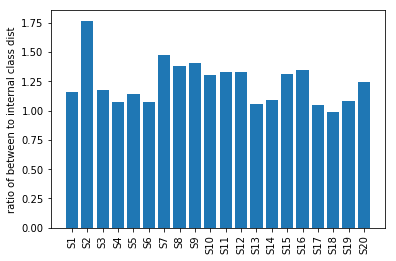

In [24]:
# calculating the dissimilarity of examples of class for each selector. 
start = 300
end = 600
classes = 3

def sel_summary(data_list): return sum([ele[0] for ele in data_list])

def data_summary(data_list):
    data_summary = []
    for d_list in data_list:
        data_summary.append(sel_summary(d_list))
    return data_summary

internal_class = []
between_class = []
labels = []
for i in range(1,21):
    labels.append('S'+str(i))
    selector = []
    for w in sorted(data.keys()):
        selector_data = data[w]['S'+str(i)]
        selector_data = selector_data.T.fillna(selector_data.mean(axis=1)).T 
        selector.append(selector_data)
    selector = pd.concat(selector, axis=1)
    selector = selector.values.T
    selector = selector[:, start:end]
#     selector = normalize_selector(selector)
    # the selector matrix is a Nxdelta_t matrix"
    # where the first half is of cheese 1 (or ethanol) and the 2nd is cheese 2 (or water)
    # OR 
    # if multiple cheeses its evenly split into three groups 
    between_class.append(indiv_sel_avg_all_to_all_dist(selector, classes))  
    internal_class.append(internal_class_dissim(selector, classes))
internal_class = data_summary(internal_class)
ratio = np.divide(between_class,internal_class)
# print(summary, between_class)
ind = range(ratio.shape[0])
fig, ax = plt.subplots()
ax.set_xticks(ind)
# ax.set_ylim([1,2.1])
ax.set_xticklabels(labels, rotation=90)
ax.set_ylabel('ratio of between to internal class dist')
plt.bar(ind,ratio)
plt.show()

#     sel_mean, sel_std = indiv_sel_avg_all_to_all_dist(selector)
#     all_data.append(('selector_{}'.format(i), sel_mean, sel_std))

In [30]:
### POST analysis: i dont think this is a good measure for utility of a selector for the classification problem...

# this cell is to look at the all combo distances between cheese 1 to cheese 2 for each of the selector individually
# the idea is to get a measure of how informative a selector is...ie is there a different between C1 and C2?
# might need to normalize the c1 to c2 distance for a given selector by how noisy it is internal to one cheese
start = 300
end = 500

all_data = []
for i in range(1,21):
    selector = []
    for w in sorted(data.keys()):
        selector_data = data[w]['S'+str(i)]
        selector_data = selector_data.T.fillna(selector_data.mean(axis=1)).T 
        selector.append(selector_data)
    selector = pd.concat(selector, axis=1)
    selector = selector.values.T
    selector = selector[:, start:end]
    # the selector matrix is a Nxdelta_t matrix"
    # where the first half is of cheese 1 (or ethanol) and the 2nd is cheese 2 (or water)
    sel_mean, sel_std = indiv_sel_avg_all_to_all_dist(selector)
    all_data.append(('selector_{}'.format(i), sel_mean, sel_std))
means = [ele[1] for ele in all_data]
error = [ele[2] for ele in all_data]
ind = range(len(all_data))
fig, ax = plt.subplots()
ax.set_xticks(ind)
ax.set_xticklabels([ele[0] for ele in all_data], rotation=90)
ax.set_ylabel('average internal selector distance')
plt.bar(ind,means, yerr=error)
plt.show()

TypeError: indiv_sel_avg_all_to_all_dist() missing 1 required positional argument: 'classes'

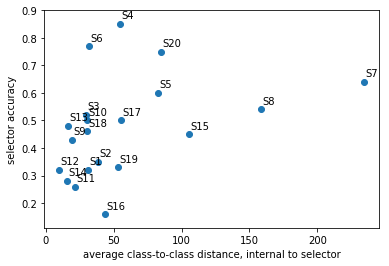

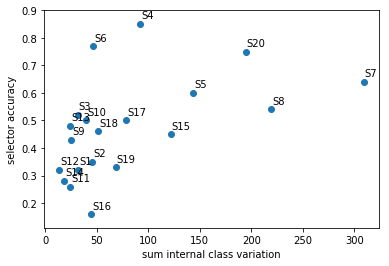

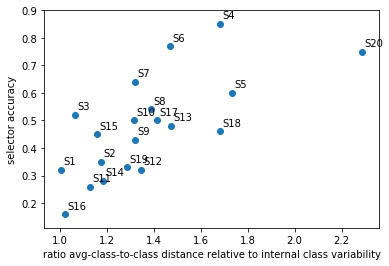

In [34]:
#### This cell is for plotting accuracies vs various interal / between class differences
#### use the accuracies from the various single selector run from above...sadly right now you manually put them in...lol

# 2 cheeses
# sel_acc = [0.47, 0.54, 0.60, 0.90, 0.875, 0.92, 0.79, 0.53, 0.43, 0.81, 
#            0.42, 0.56, 0.44, 0.19, 0.47,  0.57, 0.47, 0.46, 0.34, 0.625]
# 3 cheeses
sel_acc = [0.32, 0.35, 0.52, 0.85, 0.60, 0.77, 0.64, 0.54, 0.43, 0.5,
            0.26, 0.32, 0.48,0.28,0.45,0.16,0.50,0.46,0.33,0.75]
sel_labels = ['S1', 'S2', 'S3', 'S4', 'S5', 'S6', 'S7', 'S8', 'S9', 'S10',
              'S11', 'S12', 'S13', 'S14', 'S15', 'S16', 'S17', 'S18', 'S19', 'S20']

# plt.scatter(means, sel_acc)
plt.scatter(internal_class, sel_acc)
plt.ylabel('selector accuracy')
plt.xlabel('average class-to-class distance, internal to selector')
for i, label in enumerate(sel_labels):
    plt.annotate(label, (internal_class[i]+1, sel_acc[i]+0.02))
plt.savefig('./average_class-to-class_distance-internal_to_selector.png')
plt.show()
plt.gcf().clear()

# plt.scatter(means, sel_acc)
plt.scatter(between_class, sel_acc)
plt.ylabel('selector accuracy')
plt.xlabel('sum internal class variation')
for i, label in enumerate(sel_labels):
    plt.annotate(label, (between_class[i]+1, sel_acc[i]+0.02))
plt.savefig('./sum_internal_class_variation.png')
plt.show()
plt.gcf().clear()

# plt.scatter(means, sel_acc)
plt.scatter(ratio, sel_acc)
plt.ylabel('selector accuracy')
plt.xlabel('ratio avg-class-to-class distance relative to internal class variability')
for i, label in enumerate(sel_labels):
    plt.annotate(label, (ratio[i]+0.01, sel_acc[i]+0.02))
plt.savefig('./ratio_class-to-class_v_internal_to_class.png')
plt.show()